In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import cv2

class CountPainter:
    xstart = 0
    xend = 0
    xdelta = 0
    xnum = 0
    ystart = 0
    yend = 0
    ydelta = 0
    ynum = 0
    record = [[]]
    coldcolor = 0
    hotcolor = 0
    bgcolor = 0
    piexlsize = 0
    errors = 0
    count = 0
    norfunc = 0
    
    def __init__(self, xdata, ydata, delta, coldcolor = [255, 0, 0, 255], hotcolor = [0, 255, 0, 255], bgcolor = [255,255,255,255], piexlsize = 10, norfunc = lambda x,y:abs(x)/y):
        self.xstart = xdata[0]
        self.xend = xdata[1]
        self.xdelta = delta
        self.xnum = math.ceil((self.xend - self.xstart) / delta)
        self.ystart = ydata[0]
        self.yend = ydata[1]
        self.ydelta = delta
        self.ynum = math.ceil((self.yend - self.ystart) / delta)
        self.coldcolor = np.array(coldcolor)
        self.hotcolor = np.array(hotcolor)
        self.piexlsize = piexlsize
        self.record = np.zeros((self.xnum, self.ynum), dtype=np.int)
        self.errors = 0
        self.count = 0
        self.norfunc = norfunc
        self.bgcolor = np.array(bgcolor)
        
    def add(self, x, y, v):
        self.count += 1
        if x < self.xstart or x >= self.xend or y < self.ystart or y >= self.yend:
            self.errors += 1
            return
        self.record[math.floor((x-self.xstart)/self.xdelta)][math.floor((y-self.ystart)/self.ydelta)] += v
    
    def report(self):
        return (self.errors, self.count)
    
    def paint(self):
        img = np.zeros((self.ynum * self.piexlsize, self.xnum*self.piexlsize, 4), np.uint8)
        maxval = 1
        for i in range(len(self.record)):
            if maxval < max(np.abs(self.record[i])):
                maxval = max(np.abs(self.record[i]))
        for i in range(self.xnum):
            for j in range(self.ynum):
                val = self.record[i][j]
                if val != 0:
                    color = self.getColor(self.norfunc(val, maxval), val > 0)
                else:
                    color = (0, 0, 0, 0)
                cv2.rectangle(img, (i * self.piexlsize, j * self.piexlsize), ((i+1) * self.piexlsize, (j+1) * self.piexlsize), color, -1)
        return img
    
    def getColor(self, val, isHot):
        if isHot:
            return ((self.hotcolor - self.bgcolor)*val+self.bgcolor).astype(np.int32).tolist()
        else:
            return ((self.coldcolor - self.bgcolor)*val+self.bgcolor).astype(np.int32).tolist()

In [9]:
def loadcsv(path):
    rawdata = pd.read_csv(path)
    print("loadcsv: {} {} lines".format(path, len(rawdata)))
    return rawdata.dropna(subset = ['Latitude', 'Longitude'])

In [10]:
squarefun = lambda x,y:(pow(y,2)-pow((x-y),2))/pow(y,2)
linefunc = lambda x,y: (1-0.2)/y*abs(x)+0.2
linefunc1 = lambda x,y: (1-0.1)/y*abs(x)+0.1
linezerofunc = lambda x,y: abs(x)/y
norfunc = linezerofunc
#lineigfunc = lambda x,y: (1-0.2)/y*abs(x)+0.2 if (1-0.2)/y*abs(x)+0.2 > 0.2 else 0
xrange = [-0.6, 0.3]
yrange = [51.25, 51.70]
gridsize = 0.01
pxsize = 10
summercolor = [0,0,255,255]
wintercolor = [255,0,0,255]

loadcsv: ./data/2018-12-metropolitan-street.csv 87317 lines
loadcsv: ./data/2019-01-metropolitan-street.csv 88671 lines
loadcsv: ./data/2019-02-metropolitan-street.csv 86620 lines


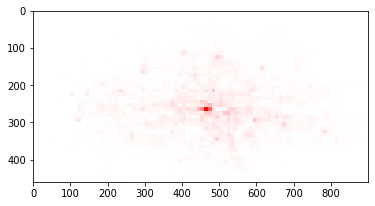

In [11]:
winterpainter = CountPainter(xrange, yrange, gridsize,piexlsize=pxsize, coldcolor=wintercolor, norfunc=norfunc)
diffpainter = CountPainter(xrange, yrange, gridsize,piexlsize=pxsize, coldcolor=wintercolor, hotcolor=summercolor, norfunc=norfunc)
summerpainter = CountPainter(xrange, yrange, gridsize,piexlsize=pxsize, hotcolor=summercolor, norfunc=norfunc)

pathlist = ['2018-12-metropolitan-street.csv', '2019-01-metropolitan-street.csv', '2019-02-metropolitan-street.csv']
rootdir= './data/'

for path in pathlist:
    winterdata = loadcsv(rootdir + path)
    for index, row in winterdata.iterrows():
        winterpainter.add(row["Longitude"], row["Latitude"], -1)
        diffpainter.add(row["Longitude"], row["Latitude"], -1)
winterimg = winterpainter.paint()
plt.imshow(winterimg)

loadcsv: ./data/2019-06-metropolitan-street.csv 95942 lines
loadcsv: ./data/2019-07-metropolitan-street.csv 99329 lines
loadcsv: ./data/2019-08-metropolitan-street.csv 91534 lines


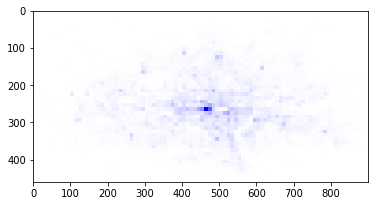

In [12]:
pathlist = ['2019-06-metropolitan-street.csv', '2019-07-metropolitan-street.csv', '2019-08-metropolitan-street.csv']
for path in pathlist:
    summerdata = loadcsv(rootdir + path)
    for index, row in summerdata.iterrows():
        summerpainter.add(row["Longitude"], row["Latitude"], 1)
        diffpainter.add(row["Longitude"], row["Latitude"], 1)
summerimg = summerpainter.paint()
plt.imshow(summerimg)

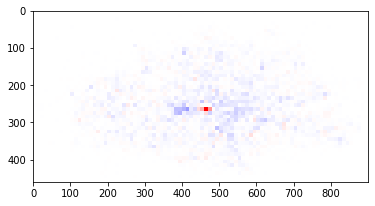

In [13]:
diffimg = diffpainter.paint()
plt.imshow(diffimg)

In [14]:
cv2.imwrite("./imgs/london_street_all_winter.png", winterimg)
cv2.imwrite("./imgs/london_street_all_summer.png", summerimg)
cv2.imwrite("./imgs/london_street_all_diff.png", diffimg)

True